# Лабораторная работа 8. Обучение GAN


### Работу выполнил:<span style="color:blue"> {Фамилия Имя}</span>

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EnlWxp5U5ltDnKRLrXxhnEABn2aLsFNyW5RthdFcoBXNgA)

### Лабораторная работа подготовлена по материалам "Sberbank Summer School. Трек Data Science"

### Как работают GAN

Идея GAN довольно проста. Предположим, мы пытаемся обучать сеть (назовем ее *сеть 1*), которая умеет создавать новые объекты из шума. Когда мы имеем подобную сеть, возникает вопрос: как наша сеть поймет, что она создала хорошие картинки, которые похожи на реальные?

Есть несколько способов решить эту проблему. Например, сравнивать распределения между объектами, генерируемыми сетями, и объектами из реальной природы. Однако можно решить данную проблему сильно проще: давайте кто-то будет сравнивать сгенерированные объекты с настоящими. И этим «кто-то» может быть вторая нейронная сеть (*сеть 2*), решающая задачу классификации, настоящий перед ней объект или искусственно сгенерированный. Первая сеть обычно называется <span style="color:blue">**генератор** </span>, а вторая <span style="color:red">**дискриминатор**</span>.

Соответственно, наша **GAN**-модель — это сочетание **2 нейронных сетей**, <span style="color:blue">**генератора** </span> и <span style="color:red">**дискриминатора**</span>, которые соревнуются и пытаются обойти друг друга, создавая все более реалистичные изображения.


![Alt text](https://www.nonteek.com/wp-content/uploads/2018/01/GAN_en.png "Пример адверсальной атаки")
*источник*: https://www.nonteek.com/en/machine-learning-gans/


### GAN на практике



#### Инициализация среды

Для работы в данном ноутбуке будем пользоваться библиотеками [PyTorch](https://pytorch.org/) и [TorchVision](https://pytorch.org/vision/stable/index.html) в качестве инструмента работы с нейронными сетями.

Импортируем необходимые модули.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

Зафиксируем random seed, чтобы сделать эксперименты воспроизводимыми.

In [ ]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  42


Для более быстрого обучения нейронных сетей в `PyTorch` можно использовать видеокарту, поддерживающую технологию CUDA.

Если вы работаете в Google Colab, не забудьте выбрать **среду выполнения GPU**.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Подготовка данных

В качестве датасета возьмём датасет [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Датасет представляет собой черно-белые картинки размером 28 x 28 пикселей с изображением элементов одежды. Всего в датасете 10 классов.

Создадим классы Dataset и Dataloader для тренировочной и тестовой части нашего датасета.

In [ ]:
batch_size = 128
image_size = 32

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])

dataset = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=True,
                                        download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Посмотрим, как выглядит датасет.

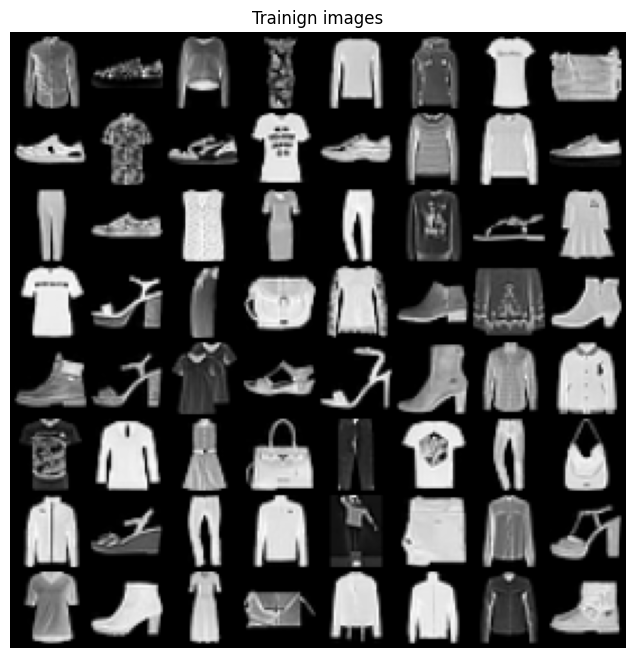

In [ ]:
def grid_visual(batch, n_pictures=64, label=''):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(label)

    pictures = batch[0].to(device)[:n_pictures]
    vis_grid = vutils.make_grid(pictures, padding=2, normalize=True).cpu()
    vis_grid = np.transpose(vis_grid,(1,2,0))

    plt.imshow(vis_grid)

real_batch = next(iter(dataloader))
grid_visual(real_batch, n_pictures=64, label='Trainign images')

## Обучение модели

### Подробнее про модели

Модель <span style="color:blue">**генератора** </span> будем обозначать через G(z), где z — латентный вектор, из которого происходит генерация. В нашем примере будем брать случайный шум в качестве этого вектора. Генератор принимает на вход латентный вектор и создает из него картинку. Соответственно, на выходе у генератора будет трехмерный тензор (многомерная матрица), в котором размерности — длина изображения, ширина изображения и количество каналов (если хотим сделать картинку цветной, нам надо сгенерировать 3 канала для красного, зеленого и синего цветов).

Модель <span style="color:red">**дискриминатора** </span> будем обозначать через D(x). Данная модель принимает на вход картинку (все еще трехмерный тензор) и решает задачу бинарной классификации: определяет, является ли наша картинка настоящей или сгенерированной. Сгенерированные картинки мы будем обозначать через класс 0, настоящие — через класс 1.

### Определим параметры реализации генератора и дискриминатора

Создадим модели генератора и дискриминатора. В качестве моделей мы будем использовать CNN-модели. Генератор и дискриминатор будут представлять из себя симметричные сетки с 4 блоками, состоящими из слоя convolution, слоя batch-normalization и функции активации.

В качестве латентного вектора мы будем использовать вектор случайного шума размерностью 100.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size=128, size=64):
        super(Generator, self).__init__()

        self.seq = nn.Sequential(

            nn.ConvTranspose2d( latent_size, size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( size * 4, size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( size * 2, size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size),
            nn.ReLU(True),

            nn.ConvTranspose2d( size, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.seq(x)


class Discriminator(nn.Module):
    def __init__(self, size=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(

            nn.Conv2d(1, size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(size, size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(size * 2, size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(size * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#Инициализируем модель генератора
latent_size = 100
model_gener = Generator(latent_size=latent_size, size=64).to(device)
model_gener

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
#Инициализируем модель дискриминатора
model_disc = Discriminator(size=64).to(device)
model_disc

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

## Обучение GAN

Рассмотрим, как будем обучать модель GAN. Для этого представим функции потерь для наших моделей.

### Генератор

Функция потерь для нашего **генератора** — бинарная кросс-энтропия от сгенерированных картинок:

$$ Loss_G = - \sum_{i=1}^n (y_i \log(\hat{y_i}) + (1 - y_i) \log(1-\hat{y_i})),  $$
$$ \hat{y_i} = D(G(\mathbf{z}_i)). $$
Здесь $y_i$ — класс объекта для дискриминатора. У сгенерированных фейковых картинок метка 0, у настоящих — 1, $\mathbf{z}_i$ — исходный латентный вектор для генерации изображения $i$, в нашем эксперименте мы будем обозначать его как случайный шум.

Однако поскольку наш генератор создает только ненастоящие картинки с классом $0$, то можно упростить функцию потерь:

$$
Loss_G = -\sum_{i=1}^n \log (1 - D(G(\mathbf{z}_i))).
$$

### Дискриминатор

Функция потерь модели **дискриминатора** — тоже бинарная кросс-энтропия:

$$
Loss_G = - \sum_{i=1}^n (y_i \log(\hat{D(\mathbf{x})}) + (1-y_i) \log(1 - \hat{D(\mathbf{x})})).  
$$
Здесь $y_i$ — истинный класс объекта (у нас 0 — фейковые картинки, 1 — настоящие), $\mathbf{x}$ — картинка, подаваемая на вход модели. Давайте немного преобразуем нашу функцию потерь.

Но в случае дискриминатора картинки могут быть как реальные, так и полученные от дискриминатора.

### Обучение

Модели мы будем обучать по очереди: сначала модель дискриминатора, потом генератор. Причина этого очень проста: если наш дискриминатор ни на что не способен, генератор не поймет, сделал он что-то стоящее или нет.

Одной итерацией будем называть:
1. прогон данных через дискриминатор и оптимизацию параметров
2. прогон данных через генератор и обучение генератора

### Реализация

В качестве функции потерь будем использовать бинарную кросс-энтропию. В качестве optimizer возьмем Adam.

In [ ]:
num_epochs = 20
lr = 0.0002

# создаем фиксированный вектор шума, из которого будем генерировать картинки
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

criterion = nn.BCELoss()

optimizer_disc = torch.optim.Adam(model_disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gener = torch.optim.Adam(model_gener.parameters(), lr=lr, betas=(0.5, 0.999))

Запустим процесс обучения:

In [ ]:
img_list = [] # будем складывать картинки, чтобы потом посмотреть, как учился наш GAN
gener_losses = [] # loss Генератора для графика
disc_losses = [] # loss Дискриминатора
iter_ = 0

n_batches = len(dataloader)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):

        #***************************************
        # Обучаем Дискриминатор
        #***************************************

        model_disc.zero_grad()

        real_images = real_images.to(device)
        BS = real_images.size(0)

        true_labels = torch.ones((BS,), dtype=torch.float, device=device)

        # прогоняем реальные картинки через дискриминатор
        pred_labels = model_disc(real_images).view(-1)
        loss_disc_real = criterion(pred_labels, true_labels)
        loss_disc_real.backward()

        # прогоняем сгенерированные картинки

        # генерим картинки
        noise = torch.randn(BS, latent_size, 1, 1, device=device)
        fake_images = model_gener(noise)
        true_labels = torch.zeros((BS,), dtype=torch.float, device=device)

        # прогоняем сгенерированные картинки через дискриминатор
        pred_labels = model_disc(fake_images.detach()).view(-1)
        loss_disc_fake = criterion(pred_labels, true_labels)
        loss_disc_fake.backward()

        # обучаем дискриминатор
        loss_disc = 0.5*(loss_disc_real + loss_disc_fake)
        optimizer_disc.step()


        #***************************************
        # Обучаем Генератор
        #***************************************

        model_gener.zero_grad()

        #Прогоняем сгенерированные картинки через дискриминатор, чтобы обучить генератор
        true_labels = torch.ones((BS,), dtype=torch.float, device=device)
        pred_labels = model_disc(fake_images).view(-1)

        # обучаем Генератор
        loss_gener = criterion(pred_labels, true_labels)
        loss_gener.backward()
        optimizer_gener.step()


        # выводим результаты
        if i % 50 == 0:
            gener_losses.append(loss_gener.item())
            disc_losses.append(loss_disc.item())
            print(f'ep {epoch}; batch {i}/{n_batches}\t Loss D: {loss_disc.item()}\tLoss G: {loss_gener.item()}')


        if (iter_ % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_images = model_gener(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))

        iter_ += 1

ep 0; batch 0/469	 Loss D: 0.8031591773033142	Loss G: 1.1593319177627563
ep 0; batch 50/469	 Loss D: 0.00870219711214304	Loss G: 5.751827239990234
ep 0; batch 100/469	 Loss D: 0.014628603123128414	Loss G: 6.418922424316406
ep 0; batch 150/469	 Loss D: 0.2579645812511444	Loss G: 1.7278804779052734
ep 0; batch 200/469	 Loss D: 0.1630559265613556	Loss G: 4.018416404724121
ep 0; batch 250/469	 Loss D: 0.27036404609680176	Loss G: 1.745804786682129
ep 0; batch 300/469	 Loss D: 0.22965475916862488	Loss G: 2.1989212036132812
ep 0; batch 350/469	 Loss D: 0.27917107939720154	Loss G: 1.7574024200439453
ep 0; batch 400/469	 Loss D: 0.29511958360671997	Loss G: 2.618997573852539
ep 0; batch 450/469	 Loss D: 0.28132739663124084	Loss G: 2.6111977100372314
ep 1; batch 0/469	 Loss D: 0.3928026556968689	Loss G: 1.340096116065979
ep 1; batch 50/469	 Loss D: 0.29660817980766296	Loss G: 2.4180309772491455
ep 1; batch 100/469	 Loss D: 0.3426678776741028	Loss G: 1.1791908740997314
ep 1; batch 150/469	 Loss D:

Выведем наши функции потерь:

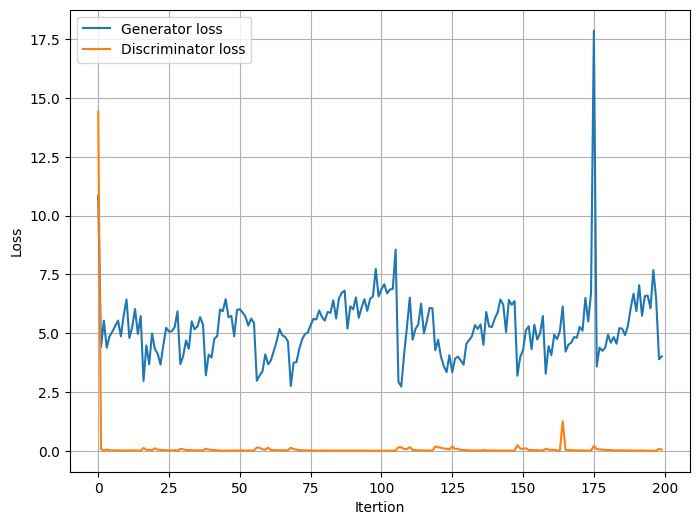

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gener_losses, label='Generator loss')
plt.plot(disc_losses, label='Discriminator loss')
plt.legend()

plt.ylabel('Loss')
plt.xlabel('Itertion')
plt.grid()
plt.show()

К сожалению, по функциям потерь моделей GAN трудно оценить сходимость модели. Обычно понимают, что GAN сошелся, когда обе функции потерь стабилизировались - перестали меняться. Также полезно выводить результаты работы модели во время обучения и сравнивать их с реальными изображениями. Когда качество генерированных картинок перестанет меняться, мы поймем, что модель сошлась.

Отметим, что у нас есть скачки в функциях потерь моделей, особенно это видно по функции потерь дискриминатора. По графику можно заметить, что скачки Discriminator loss происходили, когда падала функция потерь генератора. В эти моменты генератор обучался настолько хорошо, что текущая версия дискриминатор начинала сильно ошибаться. Такие скачки периодически встречаются при обучении GAN. Это нормальный процесс, особенно в начале обучения.

Посмотрим, какие картинки создавались на разных итерациях обучения нашей модели.

In [ ]:
def grid_animation(img_list):
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")

    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    animate = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(animate.to_jshtml())

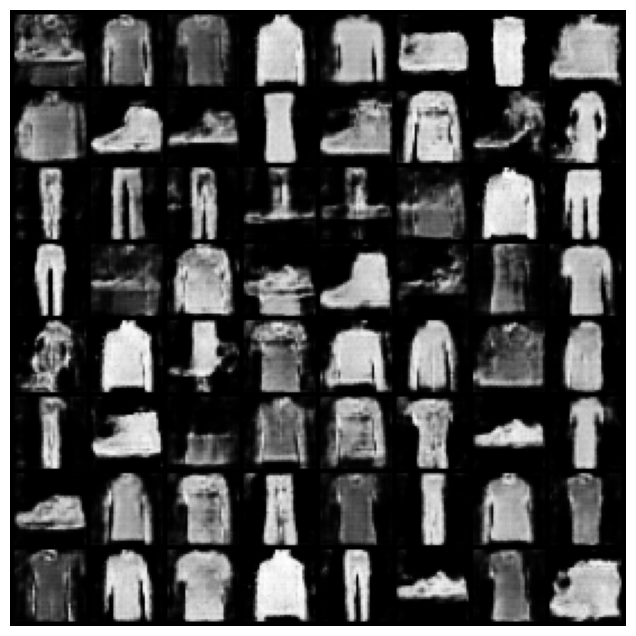

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
animate = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(animate.to_jshtml())

Сравним чуть ближе настоящие и сгенерированные изображения.

In [ ]:
def plot_images(images, label):

    len_batch = len(images)
    plt.figure(figsize=(20, 3))
    plt.title(label)

    for i in range(len(images)):

        plt.subplot(1, len_batch, i+1)
        original_img = images[i] / 2 + 0.5     # unnormalize

        matrix_image = original_img.cpu().detach().numpy()

        if matrix_image.shape[0] == 1:
            image = matrix_image[0]
            matrix_image = np.array([image, image, image])

        plt.imshow(np.transpose(matrix_image, (1, 2, 0)))
        plt.axis('off')

C:\Users\Bear\AppData\Local\Temp\ipykernel_14928\4026290727.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len_batch, i+1)


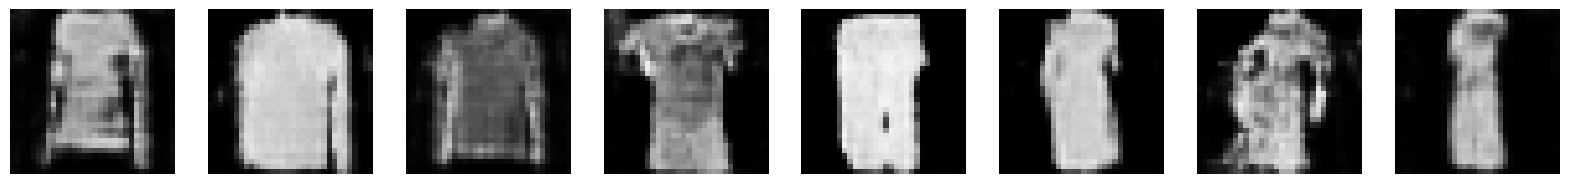

In [ ]:
n_images = 8

noise = torch.randn(n_images, latent_size, 1, 1, device=device)
images = model_gener(noise)

plot_images(images, label='Сгенерированные изображения')

C:\Users\Bear\AppData\Local\Temp\ipykernel_14928\4026290727.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len_batch, i+1)


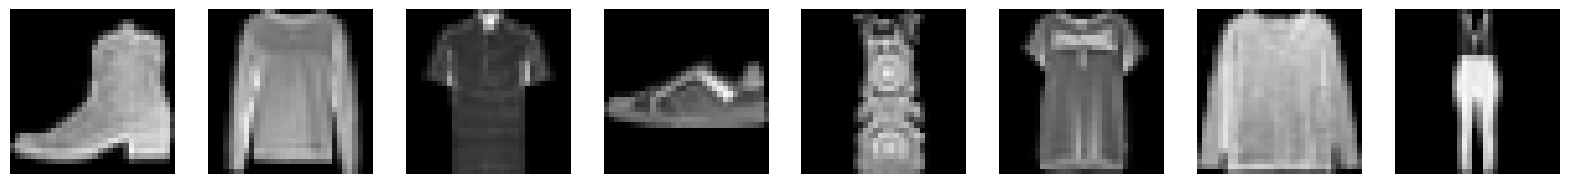

In [ ]:
n_images = 8

dataiter = iter(dataloader)
images, _ = next(dataiter)
images_sample = images[:n_images]

plot_images(images_sample, label='настоящие изображения')

Как мы видим, сгенерированные изображения довольно похожи на настоящие, но все еще отличимы. Чтобы получить более высокое качество, можно было бы поэкспериментировать с архитектурой сетей, lr, количеством эпох, другими параметрами нашего эксперимента и другими генеративными моделями.

**Задание 1.** Обучите генерировать кошек GAN (архитектуры из примера выше). <a href="https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models">Оригинальный датасет кошек</a>. Обучите на 40 эпохах. Приведите примеры генерируемых изображений.

In [ ]:
from torchvision.datasets import ImageFolder

DATA_DIR = "cats"
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
dataset_cats = ImageFolder(DATA_DIR, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)])
)
dataloader_cats = torch.utils.data.DataLoader(dataset_cats, batch_size, shuffle=True, num_workers=2, pin_memory=True)

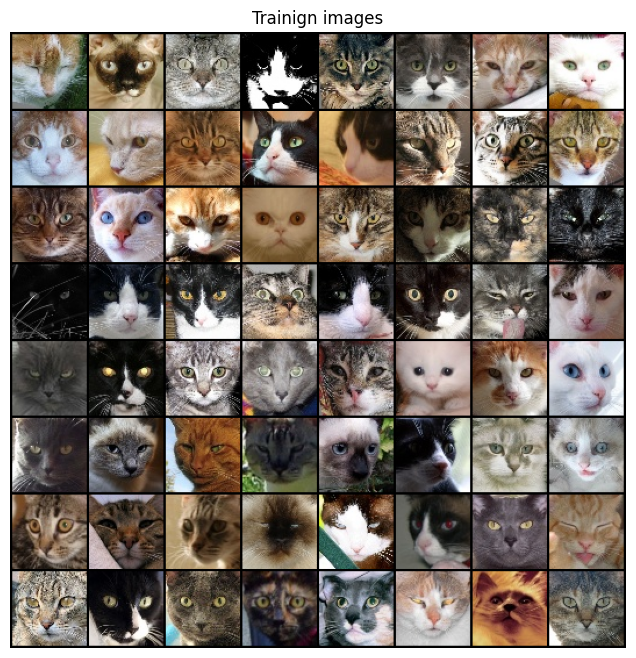

In [ ]:
real_batch = next(iter(dataloader_cats))
grid_visual(real_batch, n_pictures=64, label='Trainign images')

In [ ]:
#ваш код

**Задание 2.** Возьмите классификатор, предобученый на ImageNet. Проверьте с какой точностью классификатор распознает сгенерированные картинки кошек (на 100 картинках). Метки класса для кошек определите с помощью описания классов ImageNet.

In [ ]:
#ваш код